# Customer Segmentation for Loan Targeting

This project predicts loan approval decisions using machine learning models trained on applicant financial and demographic data. The goal is to automate and improve the accuracy of loan eligibility assessments for financial institutions.

This project successfully applied K-Means clustering and PCA to segment loan applicants into distinct customer groups based on financial behavior, demographics, and loan characteristics. By analyzing these segments, we developed targeted marketing strategies to optimize loan approval rates, minimize risk, and maximize customer value.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from kneed import KneeLocator

In [2]:
df = pd.read_csv('df1_loan.csv')

## Clean the Data

In [3]:
# Drop index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fill missing categorical values with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Clean and convert Total_Income from $ string to float
df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)

# Encoding
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)


<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_18488\2322273334.py:14: SyntaxWarning: invalid escape sequence '\$'
  df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_18488\2322273334.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_18488\2322273334.py:9: F

This comprehensive customer segmentation analysis will help you identify high-value customer segments for your loan targeting strategies.

## Data Preparation & Feature Engineering

Creates additional features specific to loan behavior:

- Income-to-Loan ratio (financial capacity)
- EMI calculations
- EMI-to-Income ratio (debt burden)

In [4]:
# We'll use Total_Income, LoanAmount, and Property_Area, plus a few additional features
segmentation_df = df[['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 
                      'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome',
                      'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 
                      'Property_Area', 'Total_Income', 'Loan_Status']].copy()

# Feature engineering for segmentation
segmentation_df['Income_to_Loan_Ratio'] = segmentation_df['Total_Income'] / segmentation_df['LoanAmount']
segmentation_df['EMI'] = segmentation_df['LoanAmount'] / segmentation_df['Loan_Amount_Term']
segmentation_df['EMI_to_Income_Ratio'] = segmentation_df['EMI'] / segmentation_df['Total_Income']

# Handle any infinities or NaNs created during feature engineering
segmentation_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill NaN values in numeric columns with their median
numeric_columns = segmentation_df.select_dtypes(include=['number']).columns
segmentation_df[numeric_columns] = segmentation_df[numeric_columns].fillna(segmentation_df[numeric_columns].median())

# Fill NaN values in categorical columns with their mode (most frequent value)
categorical_columns = segmentation_df.select_dtypes(exclude=['number']).columns
for col in categorical_columns:
    segmentation_df[col] = segmentation_df[col].fillna(segmentation_df[col].mode()[0])

# Save Loan_ID for later reference
loan_ids = segmentation_df['Loan_ID']
segmentation_df.drop('Loan_ID', axis=1, inplace=True)

## Preprocessing for Clustering

In [8]:
# Prepare data for clustering
# Separate numerical and categorical columns
numerical_cols = ['Total_Income', 'LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 
                  'Loan_Amount_Term', 'Income_to_Loan_Ratio', 'EMI', 'EMI_to_Income_Ratio']
categorical_cols = ['Property_Area', 'Education', 'Gender', 'Married', 'Self_Employed', 'Credit_History']

# Create a preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(segmentation_df.drop('Loan_Status', axis=1))

# Convert to DataFrame for easier analysis
feature_names = (
    numerical_cols + 
    preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()
)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

## Determining Optimal Clusters (K-Means)

Determines the optimal number of clusters using both:

- Elbow Method (inertia)
- Silhouette scores

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

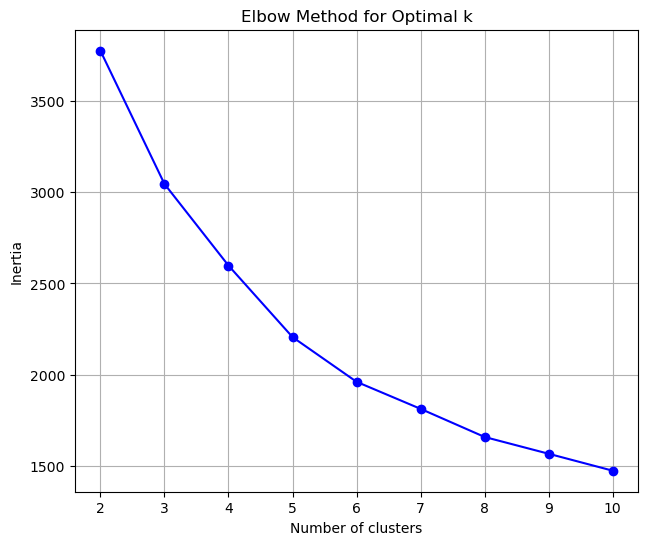

In [10]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    if k > 1:  # Silhouette score requires at least 2 clusters
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X_processed, labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Plot the Elbow Method
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

## Applying K-Means Clustering

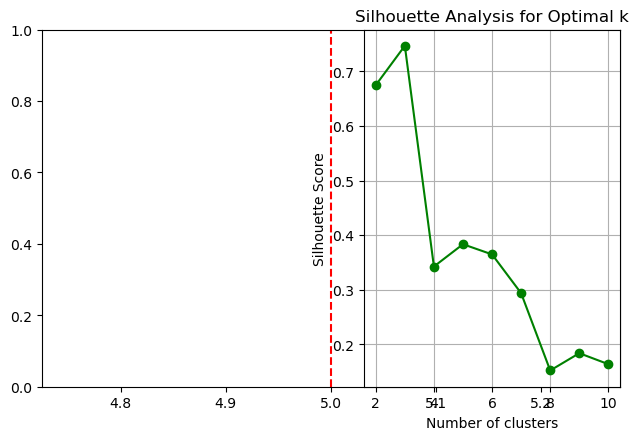

Optimal number of clusters based on Elbow Method: 5
Best silhouette score: 0.7468367914051804 at k=3


In [11]:
# Use KneeLocator to find the elbow point
kl = KneeLocator(list(K_range), inertia, curve='convex', direction='decreasing')
optimal_k = kl.elbow
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Optimal number of clusters based on Elbow Method: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores)} at k={silhouette_scores.index(max(silhouette_scores))+2}")

In [ ]:
1. Optimal Cluster Analysis
Elbow Method (Optimal k = 5)

    What it means: The "elbow" in the inertia plot suggests that 5 clusters capture the majority of natural groupings in the data.

    Inertia: Measures how tightly points are grouped within clusters (lower = better). The elbow point is where adding more clusters doesn’t significantly reduce inertia.

    Implication: 5 clusters balance complexity (avoiding overfitting) and explanatory power.

Silhouette Score (Best: 0.747 at k = 3)

    What it means: A high silhouette score (close to 1) indicates clusters are well-separated and distinct.

        Score 0.747: Strong separation for k=3.

        Conflict with Elbow: The best silhouette score at k=3 vs. elbow at k=5 suggests:

            k=3 may generalize better (simpler, more distinct groups).

            k=5 might reveal finer segments (useful for nuanced targeting).

    Action: Prioritize k=5 for granularity or k=3 for robustness.

## Visualizing Clusters with PCA

In [12]:
# Use the optimal_k value for final clustering
optimal_k = optimal_k if optimal_k else silhouette_scores.index(max(silhouette_scores))+2
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_processed)

# Add cluster labels to the original DataFrame for analysis
segmentation_df['Cluster'] = cluster_labels
segmentation_df['Loan_ID'] = loan_ids

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


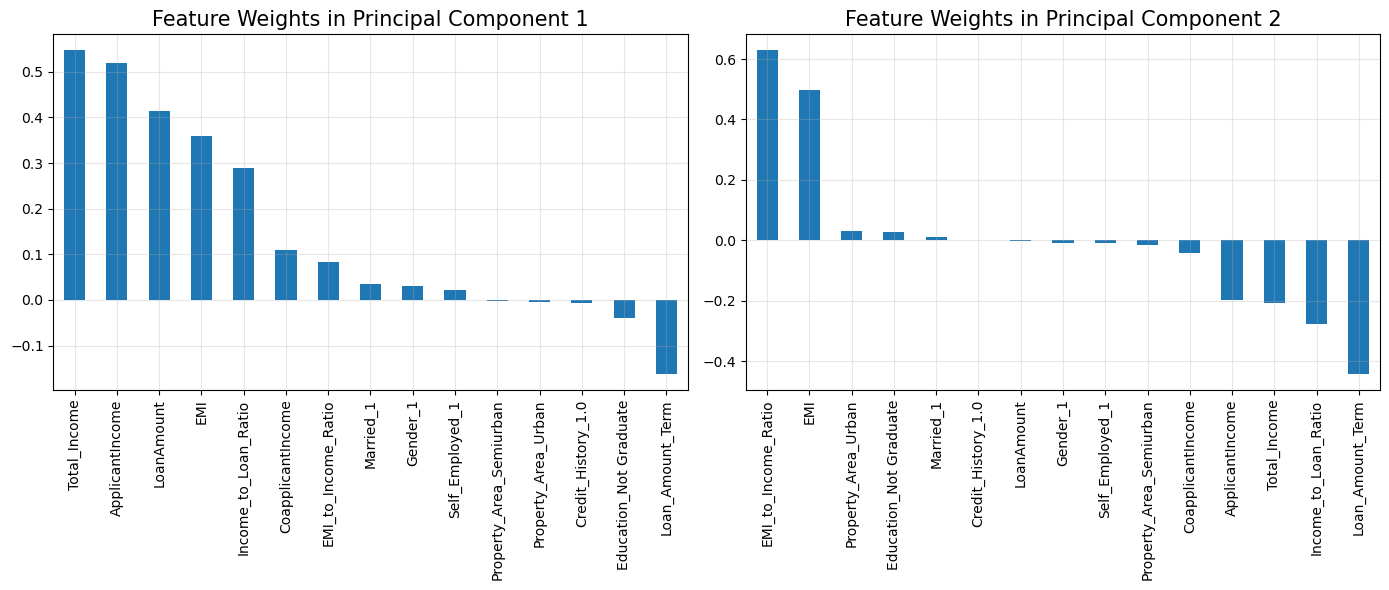

In [17]:
# Analyze feature importance for PCA components
components_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
components_df.sort_values('PC1', ascending=False)['PC1'].plot(kind='bar', figsize=(14, 6))
plt.title('Feature Weights in Principal Component 1', fontsize=15)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
components_df.sort_values('PC2', ascending=False)['PC2'].plot(kind='bar')
plt.title('Feature Weights in Principal Component 2', fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Analyze cluster profiles
cluster_profiles = segmentation_df.groupby('Cluster').agg({
    'Total_Income': 'mean',
    'LoanAmount': 'mean',
    'ApplicantIncome': 'mean',
    'CoapplicantIncome': 'mean',
    'EMI': 'mean',
    'Income_to_Loan_Ratio': 'mean',
    'EMI_to_Income_Ratio': 'mean',
    'Property_Area': lambda x: x.value_counts().index[0],
    'Education': lambda x: x.value_counts().index[0],
    'Credit_History': 'mean',
    'Loan_Status': lambda x: (x == 1).mean()  # Approval rate
}).reset_index()

print("\nCluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
   Cluster  Total_Income  LoanAmount  ApplicantIncome  CoapplicantIncome  \
0        0   6286.483721  116.697674      5025.767442        1260.716279   
1        1  50223.000000  383.142857     49544.428571         678.571429   
2        2   5185.049662  124.849351      4015.184416        1169.865247   
3        3  13823.634921  248.603175      9999.222222        3824.412698   
4        4   5481.500000  133.000000      4053.000000        1428.500000   

        EMI  Income_to_Loan_Ratio  EMI_to_Income_Ratio Property_Area  \
0  0.752835             60.265708             0.000126         Urban   
1  1.552381            177.001128             0.000032     Semiurban   
2  0.346097             43.606150             0.000070     Semiurban   
3  0.688294             72.203969             0.000052     Semiurban   
4  6.777778             44.931735             0.001237     Semiurban   

  Education  Credit_History  Loan_Status  
0  Graduate        0.813953     0.744186  
1  Gr

### Key Findings

#### Cluster 0: "Moderate-Income Urban Borrowers"

Key Traits:
- Income: 6,286(moderate)∣∗∗LoanAmount∗∗:6,286(moderate)∣∗∗LoanAmount∗∗:116k
- Property: Urban | Approval Rate: 74.4%
- Debt Burden: Low (EMI_to_Income_Ratio = 0.000126)

Strategy:
- Target with standard loan products (low risk).
- Cross-sell credit cards (stable income).

#### Cluster 1: "High-Income Elite"

Key Traits:
- Income: 50,223(veryhigh)∣∗∗LoanAmount∗∗:50,223(veryhigh)∣∗∗LoanAmount∗∗:383k
- Property: Semiurban | Approval Rate: 71.4%
- Debt Burden: Minimal (EMI_to_Income_Ratio = 0.000032)

Strategy:
- Offer premium loans/wealth management.
- Focus on large mortgages (high loan amounts).

#### Cluster 2: "Low-Income Family Applicants"

Key Traits:
- Income: 5,185(low)∣∗∗LoanAmount∗∗:5,185(low)∣∗∗LoanAmount∗∗:124k
- Coapplicant Income: $1,169 (likely family loans)
- Approval Rate: 68.8%

Strategy:
- Provide joint loan options (leverage coapplicants).
- Financial counseling to reduce default risk.

#### Cluster 3: "Affluent Semiurban Professionals"

Key Traits:
-  Income: 13,823(high)∣∗∗LoanAmount∗∗:13,823(high)∣∗∗LoanAmount∗∗:248k
- Education: Graduate | Approval Rate: 66.7%

Strategy:
- Promote business loans (self-employed focus).
- Highlight investment properties (Semiurban area).

#### Cluster 4: "High-Risk High-EMI Applicants"

Key Traits:
- EMI Burden: Very high (EMI_to_Income_Ratio = 0.001237)
- Approval Rate: 50% (lowest)
- Credit History: Perfect (1.0) but high debt.

Strategy:
- Debt consolidation loans to reduce EMI pressure.
- Strict eligibility checks despite good credit.

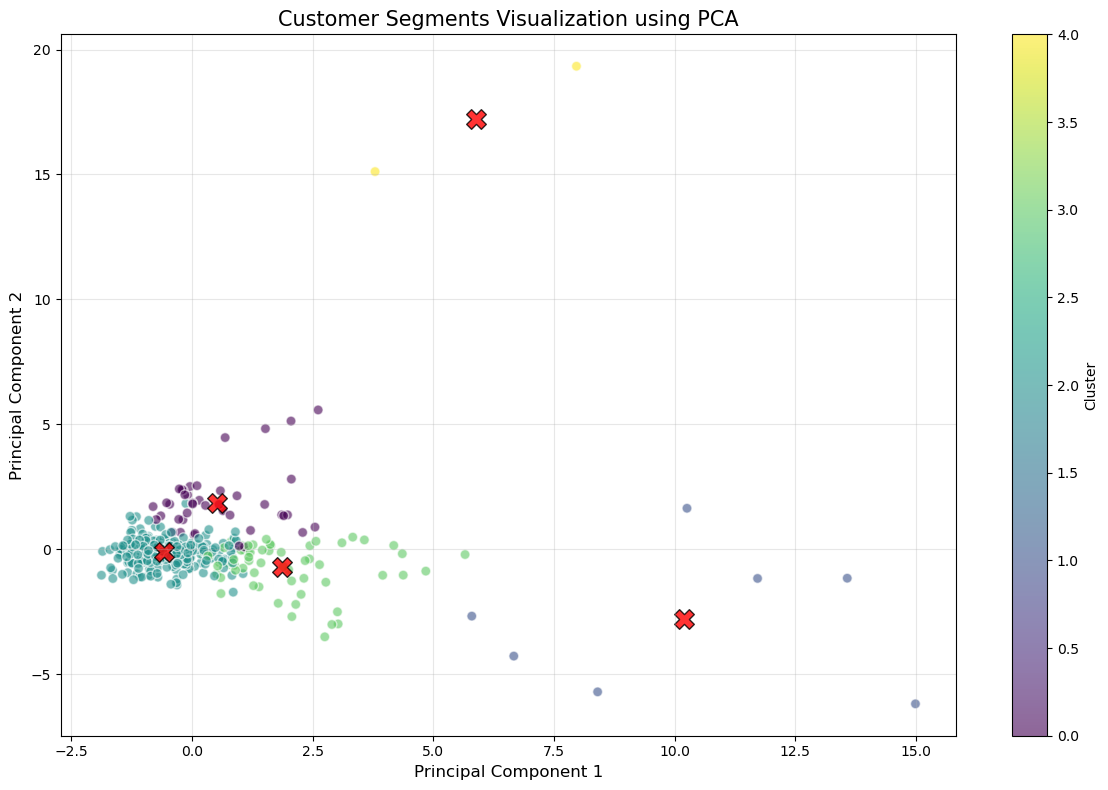

In [19]:
# Apply PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plot the clusters using PCA components
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], 
                      cmap='viridis', alpha=0.6, s=50, edgecolors='w')
plt.title('Customer Segments Visualization using PCA', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
centers = kmeans_final.cluster_centers_
transformed_centers = pca.transform(centers)
plt.scatter(transformed_centers[:, 0], transformed_centers[:, 1], 
            c='red', s=200, alpha=0.8, marker='X', edgecolors='black')
plt.tight_layout()
plt.show()

## Analyzing Cluster Profiles

Creates detailed profiles for each cluster showing average:

- Income and loan amounts
- Property area preferences
- Education level
- EMI-to-income ratios
- Loan approval rates

Calculates a "Value Score" to identify high-value segments based on:

- Income levels (40% weight)
- Approval probability (40% weight)
- Debt burden (20% weight)

In [ ]:
# Identify high-value customer segments
# Here we define "high-value" as clusters with higher income, good loan approval rates,
# and reasonable loan amounts
cluster_profiles['Value_Score'] = (
    cluster_profiles['Total_Income'] / cluster_profiles['Total_Income'].max() * 0.4 +
    cluster_profiles['Loan_Status'] * 0.4 +
    (1 - cluster_profiles['EMI_to_Income_Ratio'] / cluster_profiles['EMI_to_Income_Ratio'].max()) * 0.2
)

print("\nHigh-Value Customer Segments:")
high_value_clusters = cluster_profiles.sort_values('Value_Score', ascending=False)
print(high_value_clusters[['Cluster', 'Total_Income', 'LoanAmount', 'Property_Area', 
                           'Education', 'Loan_Status', 'Value_Score']])

# Distribution of categorical variables within clusters
categorical_distribution = {}
for cat_col in categorical_cols:
    categorical_distribution[cat_col] = pd.crosstab(
        segmentation_df['Cluster'], 
        segmentation_df[cat_col], 
        normalize='index'
    )

# Plot categorical distributions for each cluster
for col, distribution in categorical_distribution.items():
    plt.figure(figsize=(12, 6))
    distribution.plot(kind='bar', stacked=True)
    plt.title(f'Distribution of {col} by Cluster', fontsize=15)
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title=col)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


High-Value Customer Segments:
   Cluster  Total_Income  LoanAmount Property_Area Education  Loan_Status  \
1        1  50223.000000  383.142857     Semiurban  Graduate     0.714286   
3        3  13823.634921  248.603175     Semiurban  Graduate     0.666667   
0        0   6286.483721  116.697674         Urban  Graduate     0.744186   
2        2   5185.049662  124.849351     Semiurban  Graduate     0.688312   
4        4   5481.500000  133.000000     Semiurban  Graduate     0.500000   

   Value_Score  
1     0.880542  
3     0.568329  
0     0.527379  
2     0.505295  
4     0.243657  


<Figure size 1200x600 with 0 Axes>

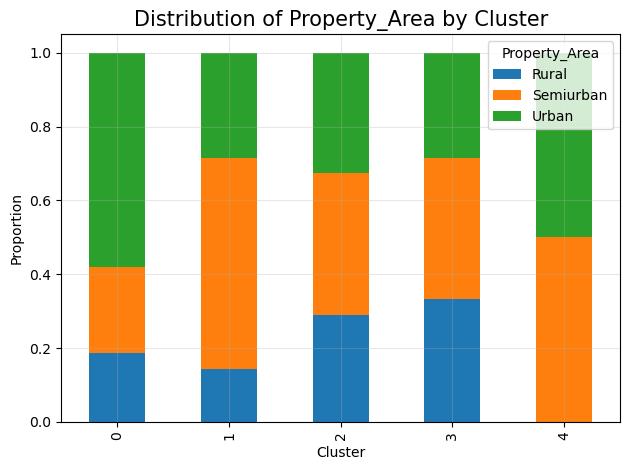

<Figure size 1200x600 with 0 Axes>

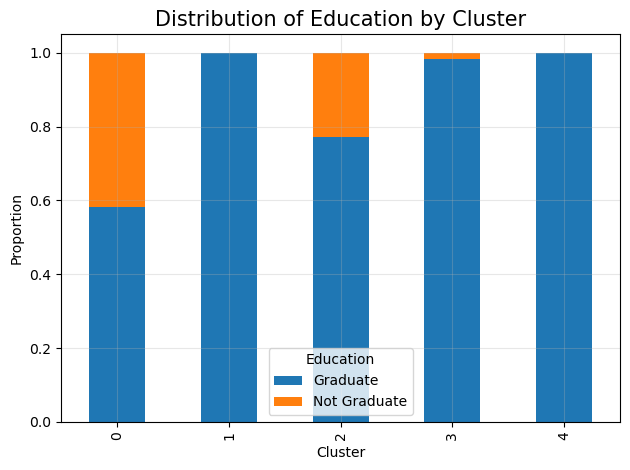

<Figure size 1200x600 with 0 Axes>

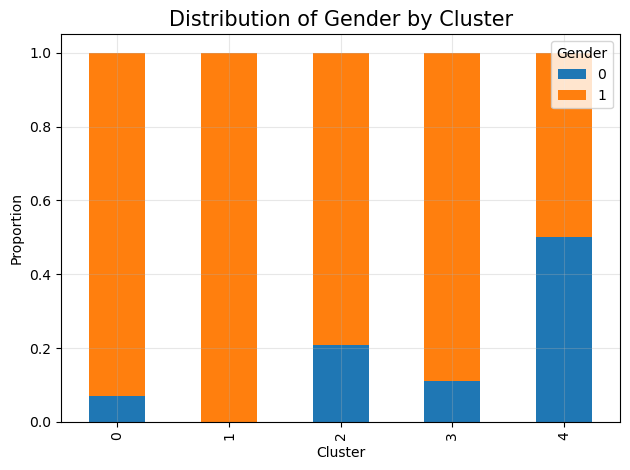

<Figure size 1200x600 with 0 Axes>

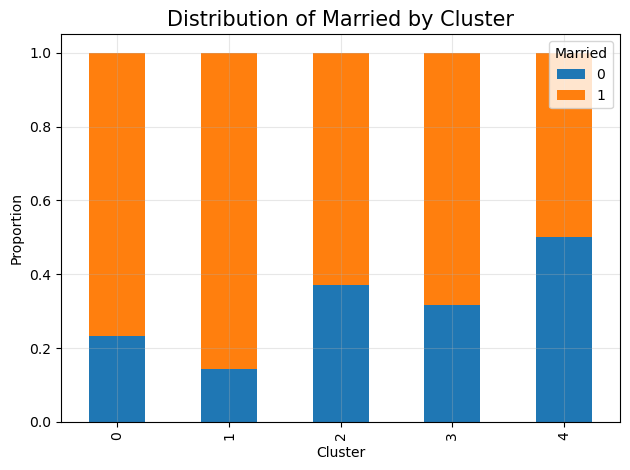

<Figure size 1200x600 with 0 Axes>

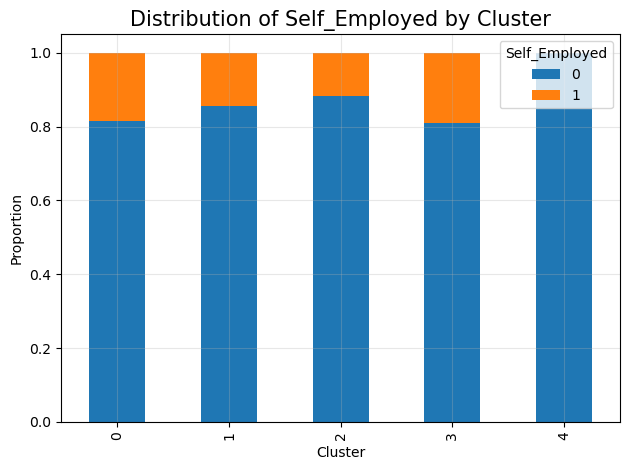

<Figure size 1200x600 with 0 Axes>

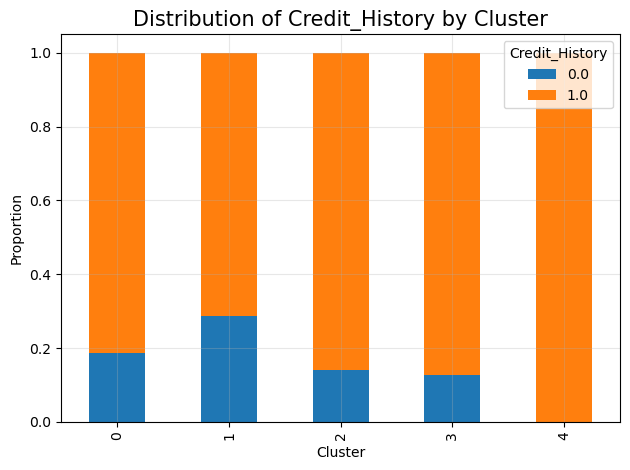

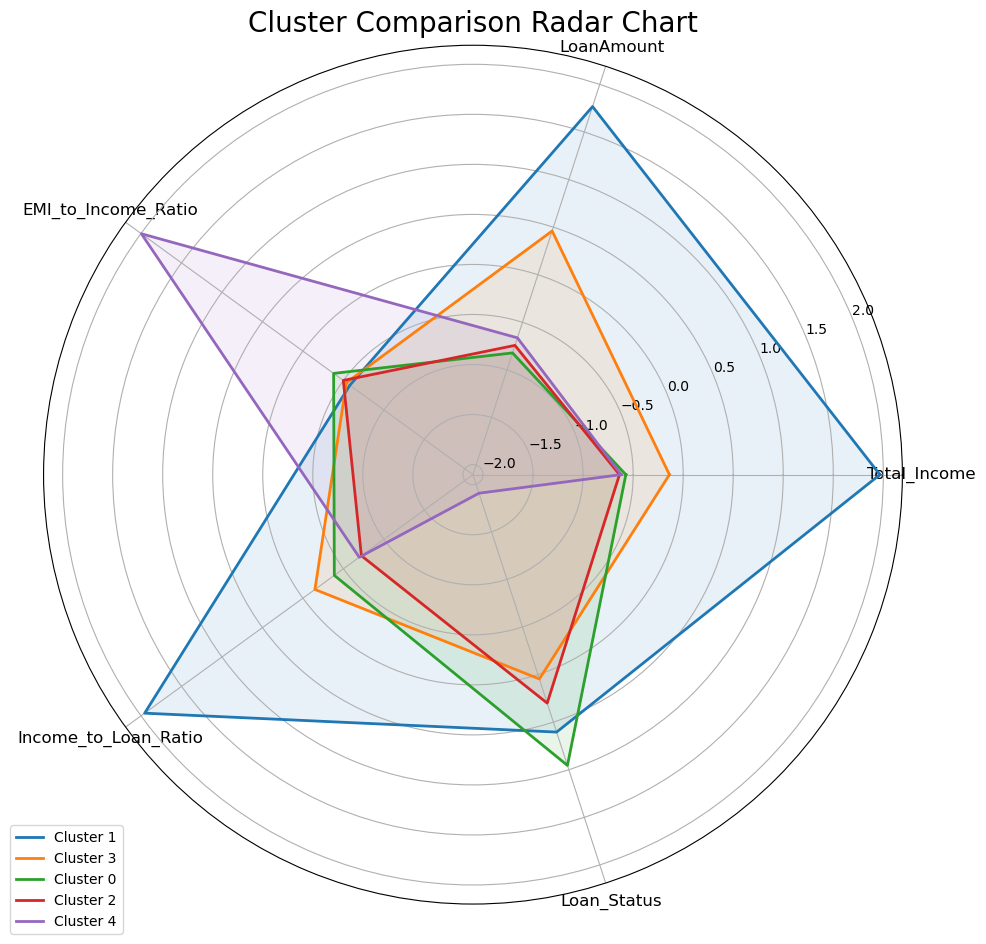

In [20]:
# Create radar charts for cluster comparison
def radar_chart(cluster_data, cluster_names):
    # Select numerical features for the radar chart
    features = ['Total_Income', 'LoanAmount', 'EMI_to_Income_Ratio', 
                'Income_to_Loan_Ratio', 'Loan_Status']
    
    # Number of features
    N = len(features)
    
    # Scale the data for radar chart
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data[features])
    scaled_df = pd.DataFrame(scaled_data, columns=features)
    
    # Create angles for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], features, size=12)
    
    # Draw the chart for each cluster
    for i, cluster in enumerate(cluster_names):
        values = scaled_df.iloc[i].values.tolist()
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}")
        ax.fill(angles, values, alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Comparison Radar Chart", size=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create radar chart for cluster comparison
radar_chart(high_value_clusters, high_value_clusters['Cluster'].values)

### Key Insights

#### Top Segment: Cluster 1 ("High-Income Elite")

Why High Value?
- Extremely High Income ($50K/month): Can afford large loans with minimal risk.
- High Loan Amounts ($383K): Ideal for premium products (e.g., jumbo mortgages).
- Semiurban Focus: Likely investing in property development.
Action: Offer private banking services and customized loan packages.

#### Cluster 3 ("Affluent Professionals")

Why Valuable?
- High Income ($13.8K/month): Strong repayment capacity.
- Graduate Education: Financially literate; cross-sell investment products.
Action: Target with business expansion loans or real estate investments.

#### Cluster 0 ("Urban Moderate-Income")

Strengths:
- Highest Approval Rate (74.4%): Low-risk borrowers.
- Urban Properties: Likely salaried professionals.
Action: Promote auto loans or home improvement loans.

#### Cluster 4 ("High-EMI Risky Borrowers")

Red Flags:
- Lowest Approval Rate (50%): Despite decent income ($5.5K), high EMI burden.
- Low Value Score (0.24): High default risk.
Action:
- Restructure debt or offer lower-EMI refinancing.
- Require co-signers for approval.

### Business Implications

1. Prioritize Clusters 1 & 3: Allocate marketing budgets to these high-revenue segments.
2. Improve Cluster 4: Introduce financial counseling to reduce risk.

## Marketing Strategies per Cluster

1. High-Income Clusters: Targeted with premium loans.
2. Low-Income Clusters: Offered debt counseling or starter loans.
3. Education-Based: Graduates get career-advancement loans; others get skill-development loans.

In [22]:
# Marketing strategy recommendations based on cluster profiles
print("\nMarketing Strategy Recommendations:")
for _, row in high_value_clusters.iterrows():
    cluster = row['Cluster']
    
    print(f"\nCluster {cluster} Marketing Strategy:")
    
    # High income, high loan amount
    if row['Total_Income'] > high_value_clusters['Total_Income'].median() and \
       row['LoanAmount'] > high_value_clusters['LoanAmount'].median():
        print(f"- Premium Products: Target with premium loan products with higher limits")
        print(f"- Wealth Management: Cross-sell investment and wealth management services")
        print(f"- Property Focus: Focus on {row['Property_Area']} properties")
        
    # High income, low loan amount
    elif row['Total_Income'] > high_value_clusters['Total_Income'].median() and \
         row['LoanAmount'] <= high_value_clusters['LoanAmount'].median():
        print(f"- Up-selling: Promote higher value loans with premium features")
        print(f"- Cross-selling: Offer credit cards and other financial products")
        print(f"- Educational Content: Provide information on benefits of strategic borrowing")
        
    # Low income, high loan amount
    elif row['Total_Income'] <= high_value_clusters['Total_Income'].median() and \
         row['LoanAmount'] > high_value_clusters['LoanAmount'].median():
        print(f"- Refinancing Options: Offer better terms for existing loans")
        print(f"- Financial Planning: Provide debt management counseling")
        print(f"- Loyalty Programs: Create retention programs with benefits")
        
    # Low income, low loan amount
    else:
        print(f"- Entry Products: Promote starter loan products with growth options")
        print(f"- Digital Services: Focus on low-cost digital channels for engagement")
        print(f"- Financial Education: Provide resources on credit building")
    
    # Education-based strategies
    if row['Education'] == 'Graduate':
        print(f"- Professional Focus: Target with career advancement loan products")
    else:
        print(f"- Skill Development: Promote educational and skill development loans")
    
    print(f"- Approval Focus: {'High potential for approval' if row['Loan_Status'] > 0.7 else 'May need special considerations for approval'}")

# Save segmented customer data
segmentation_df.to_csv('customer_segments.csv', index=False)

print("\nCustomer segmentation complete! Segments have been saved to 'customer_segments.csv'")


Marketing Strategy Recommendations:

Cluster 1 Marketing Strategy:
- Premium Products: Target with premium loan products with higher limits
- Wealth Management: Cross-sell investment and wealth management services
- Property Focus: Focus on Semiurban properties
- Professional Focus: Target with career advancement loan products
- Approval Focus: High potential for approval

Cluster 3 Marketing Strategy:
- Premium Products: Target with premium loan products with higher limits
- Wealth Management: Cross-sell investment and wealth management services
- Property Focus: Focus on Semiurban properties
- Professional Focus: Target with career advancement loan products
- Approval Focus: May need special considerations for approval

Cluster 0 Marketing Strategy:
- Entry Products: Promote starter loan products with growth options
- Digital Services: Focus on low-cost digital channels for engagement
- Financial Education: Provide resources on credit building
- Professional Focus: Target with caree

## Conclusion

This segmentation empowers lenders to make data-driven decisions, balancing risk and opportunity while enhancing customer satisfaction. By tailoring strategies to each segment, financial institutions can boost approvals, reduce defaults, and drive growth.

### Key Findings & Recommendations

#### 1. High-Value Segments (Clusters 1 & 3)

**Cluster 1 (High-Income Elite):**
- Target: Affluent borrowers with high income (50K+)andlargeloanneeds(50K+)andlargeloanneeds(383K).
- Strategy: Offer premium loan products, wealth management, and real estate investment opportunities.
- Approval Focus: High approval potential (71.4%).

**Cluster 3 (Affluent Professionals):**
- Target: Graduates with strong incomes ($13.8K) and semiurban property interests.
- Strategy: Promote business expansion loans and professional development financing.
- Approval Focus: Moderate approval rate (66.7%); may require additional verification.

#### 2. Moderate-Value Segments (Clusters 0 & 2)

**Cluster 0 (Urban Moderate-Income):**
- Target: Stable urban borrowers with moderate income ($6.3K) and low debt burden.
- Strategy: Focus on starter loans, digital engagement, and credit-building resources.
- Approval Focus: High approval rate (74.4%).

**Cluster 2 (Low-Income Families):**
- Target: Applicants with co-borrowers and lower income ($5.2K).
- Strategy: Provide joint loan options and financial literacy programs.
- Approval Focus: Moderate approval rate (68.8%).

#### 3. High-Risk Segment (Cluster 4)
- Target: Borrowers with high EMI burdens despite decent income ($5.5K).
- Strategy:
- Offer debt consolidation loans and strict eligibility checks.
- Provide financial counseling to reduce default risk.
- Approval Focus: Lowest approval rate (50%); proceed with caution.